# Generate data

The tools we use to digest and analyze data can often take a turn to generate data, which allows us to work out routines and algorithms without actual data, as long as we understand the anticipated data schema.

The element of randomness also helps with the testing and robustness of the data process, especially with a sufficient sample size. The comprehensiveness of the randomly generated data can often rival that of the actual data.

Suppose we are to work with some dataset that contains mobile activities across designated POIs, with a good understanding of the data schema (in the sense of columns):
* `date` - the date of mobile device activities recorded
* `hour` - the hour of the date
* `day` - the day of the week of the given date
* `name` - the name of the POI
* `address` - the street address of the POI
* `city` - the city of the POI
* `region` - the region of the POI
* `country` - the country of the POI
* `device_ids` - a list of unique device IDs that were active in the given POI
* `total_counts` - number or length of the given `device_ids`

The dataset would loosely resemble the audience data we have seen from [09 - Set operations](./09-set-operations.ipynb). However, suppose we want to work out a process to perform a similar analysis without waiting for the actual data. We may be able to work with generated data using our understanding of the data schema.

## Random Device IDs

Let's generate some random UUIDs ([Universally unique identifier](https://en.wikipedia.org/wiki/Universally_unique_identifier)) using the Python built-in [`uuid`](https://docs.python.org/3/library/uuid.html) module since the real-world device IDs are often similar in shape and by nature.

In [1]:
from uuid import uuid4

device_ids = []
for _ in range(20_000):
    device_ids.append(str(uuid4()))

device_ids[:10]

['aa98ead3-fba4-481e-8d90-1396f4e32c6b',
 '6ae75d08-9d76-4d30-9dbc-dd12112312b6',
 '12c8918e-ad98-4def-b87e-487a858f6da1',
 'e49c49d1-724f-4064-9b7f-293067d5ac70',
 '9b4c6f52-97f0-4b04-91f9-f25c16163cff',
 'd5c1366c-66ff-4cb1-b9ef-8113e01ba189',
 '7d906b01-77ed-4ff1-9d3d-9fcd0f32d933',
 'ac5cc6cb-0576-4651-9d11-890bb2268533',
 '32272561-4722-487a-9942-73ec971495a1',
 'c0ac1e5d-0ce1-4060-ac23-364e25d42721']

To make it more realistic, the device IDs are often [hashed](https://en.wikipedia.org/wiki/One-way_function#Cryptographically_secure_hash_functions) as a privacy protective measure:

In [2]:
from hashlib import sha1

device_ids = [sha1(x.encode()).hexdigest() for x in device_ids]
device_ids[:10]

['6e191e6232daa58e5f1f5fccc70dd76337494b2c',
 'f58db8438ad36a0099a7a37b0d2c4b19fc2a688e',
 '3b58d7042a5d3e407a18b28caf06f0456657d893',
 '5d5b1953a556fafe560234c05a72da3fad001d25',
 '66237c660d396dcb5de6489a46d323ad970da0e6',
 'bee888283a8d45813ffb7d9927398a03feac5d4e',
 '953bc43f68904686723cc101d3b8849b9155d552',
 '9b7755996868204ec21efc1c6b635042125bf350',
 '23e0008ee90b405219a653bc491d1abc161fe908',
 'd8061ca97e542e55cd618dc53c9faa753acff154']

## Random POIs

Let's generate some POIs, starting with some fake company names and a randomly assigned number of locations per each:

In [3]:
import random

import pandas as pd
from faker import Faker

fake = Faker(['en_CA'])

companies = pd.DataFrame([
    {
        'name': fake.company(),
        'locations': random.randint(10, 500),
    }
    for _ in range(13)
])
companies

,name,locations
0,"Dominguez, Goodwin and Reese",21
1,Pham and Sons,448
2,Orr LLC,221
3,Graves-Ellis,59
4,Maddox-Sharp,367
5,"Perez, Terrell and Dillon",226
6,Thomas LLC,160
7,Barr PLC,41
8,Day LLC,416
9,James-Sims,443


Then we can build on top of the list of companies to generate some POIs using fake addresses:

In [4]:
pois = []

for company in companies.itertuples():
    for _ in range(company.locations):
        address = fake.street_address()
        city = fake.city()
        region = fake.province_abbr()
        postalcode = fake.postcode_in_province(region)
        pois.append({
            'name': company.name,
            'address': address,
            'city': city,
            'region': region,
            'postalcode': postalcode,
            'country': 'CA',
        })

pois = pd.DataFrame(pois)
pois

,name,address,city,region,postalcode,country
0,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,X6P3E3,CA
1,"Dominguez, Goodwin and Reese",42337 Norton Road,Annettemouth,YT,Y2S 9M9,CA
2,"Dominguez, Goodwin and Reese",13503 Mary Village,Williamport,AB,T9P6V5,CA
3,"Dominguez, Goodwin and Reese",00334 Holder Course Apt. 204,Perezfort,AB,T3A9P2,CA
4,"Dominguez, Goodwin and Reese",014 Hudson Lock Apt. 192,Baxterfurt,PE,C8K 6N9,CA
...,...,...,...,...,...,...
3013,Cooke-Davis,631 Murray Bypass Suite 789,New Nicoleberg,BC,V8G 6L1,CA
3014,Cooke-Davis,940 Karen Mount Suite 848,Lake James,NU,X9G5T1,CA
3015,Cooke-Davis,4720 Mays Cliff,North Ericchester,SK,S3P9X6,CA
3016,Cooke-Davis,0028 Matthew Forest,South Barbarastad,NS,B3J8P7,CA


Finally, we can generate a series of audience activities between a date range, such as the whole month of 2021 May, at an hourly frequency, and only during weekdays and the conventional work hours.

We also want to randomly distribute the pool of previously generated device IDs to each activity record.

This process can be slow, so we'll use the Jupyter Notebook cell-level magic `%%time` to reveal to us how long it takes:

In [5]:
%%time

# generate "audience" activity between designated date range among ^ POIs
audiences = []
for row in pois.itertuples():
    # generate hourly date range for a week
    for dt in pd.date_range(start='2021-05-01', end='2021-05-31', freq='H'):
        if dt.strftime('%A') in ['Saturday', 'Sunday']:
            continue

        if dt.strftime('%-H') not in [str(i) for i in range(9, 22)]:
            continue

        _ids = random.sample(device_ids, random.randint(1, 5))
        audiences.append({
            'total_counts': len(_ids),
            'device_ids': _ids,
            'hour': dt.strftime('%H'),
            'day': dt.strftime('%A'),
            'date': dt.strftime('%Y%m%d'),
            'name': row.name,
            'address': row.address,
            'city': row.city,
            'region': row.region,
            'country': row.country,
        })

CPU times: user 31.4 s, sys: 313 ms, total: 31.8 s
Wall time: 31.8 s


Load the generated audience activities into a Pandas `DataFrame`:

In [6]:
df = pd.DataFrame(audiences)
df

,total_counts,device_ids,hour,day,date,name,address,city,region,country
0,4,"[238f7f607e4b780de7604738e8e51e52ab4485d3, 6d6...",09,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
1,5,"[e421d5856caf05b9bbaaf985aeb9c08052e7be65, 678...",10,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
2,5,"[b4ab83970a59b849322c121541937da1363aaeee, 482...",11,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
3,1,[758e311521123f50cf0d1918a0e0e68ed7bff7ce],12,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
4,4,"[db8e36d681fff0a37411b27680dbc0984c743a87, 9ca...",13,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
...,...,...,...,...,...,...,...,...,...,...
784675,2,"[1978e9e38ed212649915b24dc846b030c9e5bbdb, 3af...",17,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA
784676,3,"[829ed1d343c4d26740834be3757fa77eb2a9faff, d18...",18,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA
784677,1,[a9537edb2aab08c1b1698d40d112cc6e63e04304],19,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA
784678,4,"[217f26bdd0cf6cdc04999d00cde11e5f8aed08e3, e56...",20,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA


In [7]:
df.total_counts.describe()  # a probable indicator of generated data

count    784680.000000
mean          2.997808
std           1.413887
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: total_counts, dtype: float64

The statistical description reveals a probable indicator of [(pseudo-)randomly](https://en.wikipedia.org/wiki/Pseudorandomness) generated dataset given its near-perfect _mean_ and _percentile distribution_.

The next steps follow the trace of [09 - Set operations](./09-set-operations.ipynb).

In [8]:
exp = df.explode('device_ids').drop('total_counts', axis=1).reset_index(drop=True)
exp

,device_ids,hour,day,date,name,address,city,region,country
0,238f7f607e4b780de7604738e8e51e52ab4485d3,09,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
1,6d6daf104179683abf25ca2cdc6d3d006190dd8d,09,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
2,e284d6634d46f2aa2b6df50bae9b1ef123bfe4a1,09,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
3,572a8f0847425fb2e002a32751c3cb64acc2c366,09,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
4,e421d5856caf05b9bbaaf985aeb9c08052e7be65,10,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
...,...,...,...,...,...,...,...,...,...
2352315,217f26bdd0cf6cdc04999d00cde11e5f8aed08e3,20,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA
2352316,e56e7bf845c0bc96af0b939d6ed2dd4cabfd7fee,20,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA
2352317,61d2fdc59408b3d47f5a84bed0893f3f222f7aaa,20,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA
2352318,c080ee6f8d49aa8a02a50e77ca50e523734b65d9,20,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA


Since the device IDs were randomly distributed across activities, and given the sample size, it's likely for us to encounter duplicates:

In [9]:
dedupe = exp.drop_duplicates(subset=['device_ids', 'hour', 'date'], keep='last')  # get rid of ppl with TARDIS
dedupe

,device_ids,hour,day,date,name,address,city,region,country
0,238f7f607e4b780de7604738e8e51e52ab4485d3,09,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
1,6d6daf104179683abf25ca2cdc6d3d006190dd8d,09,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
2,e284d6634d46f2aa2b6df50bae9b1ef123bfe4a1,09,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
3,572a8f0847425fb2e002a32751c3cb64acc2c366,09,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
5,67851560770ff21b1a6c2f963591536c69e07f3b,10,Monday,20210503,"Dominguez, Goodwin and Reese",0323 Weiss Village,Kingburgh,NU,CA
...,...,...,...,...,...,...,...,...,...
2352315,217f26bdd0cf6cdc04999d00cde11e5f8aed08e3,20,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA
2352316,e56e7bf845c0bc96af0b939d6ed2dd4cabfd7fee,20,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA
2352317,61d2fdc59408b3d47f5a84bed0893f3f222f7aaa,20,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA
2352318,c080ee6f8d49aa8a02a50e77ca50e523734b65d9,20,Friday,20210528,Cooke-Davis,4406 Tammy Overpass Apt. 095,East David,NB,CA


In [10]:
gb = dedupe.groupby(['name', 'day', 'hour'], as_index=False).agg({'device_ids': 'count'})
gb

,name,day,hour,device_ids
0,Barr PLC,Friday,09,406
1,Barr PLC,Friday,10,379
2,Barr PLC,Friday,11,393
3,Barr PLC,Friday,12,432
4,Barr PLC,Friday,13,389
...,...,...,...,...
840,Thomas LLC,Wednesday,17,1493
841,Thomas LLC,Wednesday,18,1568
842,Thomas LLC,Wednesday,19,1555
843,Thomas LLC,Wednesday,20,1491


Since the dataset was a random generation, there is no definitive list of POI company names.

To make this entire process rerunnable, we resort to using random choice among the generated list of company names:

In [11]:
names = gb['name'].unique().tolist()
name = random.choice(names)
name

'Stafford PLC'

In [12]:
pv = gb[gb['name'] == name].pivot('day', 'hour', 'device_ids')
pv

hour,09,10,11,12,13,14,15,16,17,18,19,20,21
day,,,,,,,,,,,,,
Friday,1740,1706,1702,1760,1759,1764,1732,1687,1757,1815,1793,1780,1825
Monday,1710,1757,1787,1784,1761,1743,1762,1746,1768,1699,1770,1733,1767
Thursday,1710,1742,1794,1790,1741,1712,1705,1705,1771,1762,1743,1775,1785
Tuesday,1737,1779,1771,1800,1784,1752,1696,1801,1821,1758,1753,1771,1751
Wednesday,1733,1758,1703,1784,1770,1717,1801,1786,1738,1797,1761,1747,1762


Visualization time:

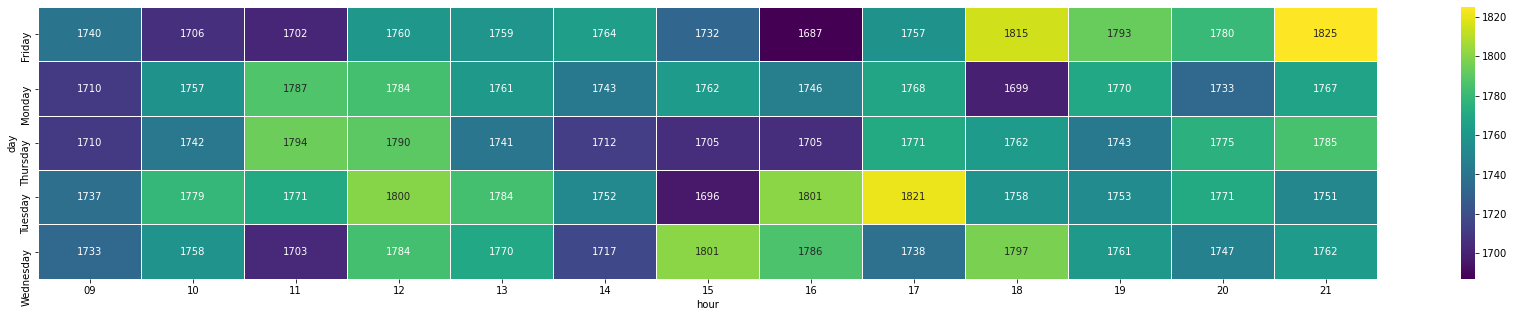

In [13]:
import matplotlib.pyplot as plot
import seaborn as sns

_, ax = plot.subplots(figsize=(30, 5))
heatmap = sns.heatmap(pv, annot=True, fmt='.0f', cmap='viridis', linecolor='white', linewidths='0.5', ax=ax)

The order of the day values seem a bit unorthodox, let's fix it with a [Pandas categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) object:

In [14]:
dedupe = dedupe.copy()
dedupe.day = pd.Categorical(dedupe.day, categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], ordered=True)

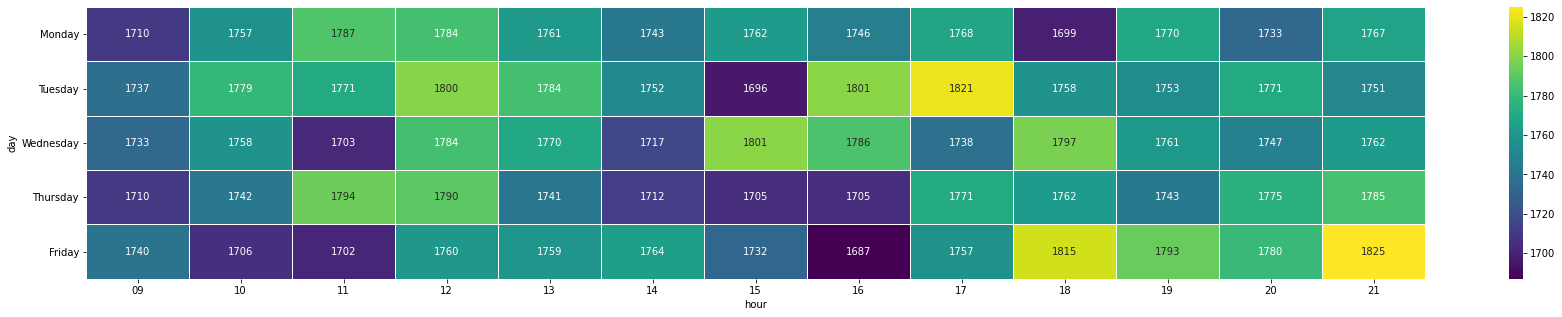

In [16]:
# rerun the previous routine
gb = dedupe.groupby(['name', 'day', 'hour'], as_index=False).agg({'device_ids': 'count'})
pv = gb[gb['name'] == name].pivot('day', 'hour', 'device_ids')
_, ax = plot.subplots(figsize=(30, 5))
heatmap = sns.heatmap(pv, annot=True, fmt='.0f', cmap='viridis', linecolor='white', linewidths='0.5', ax=ax)

Abstract the visualization logic into a function:

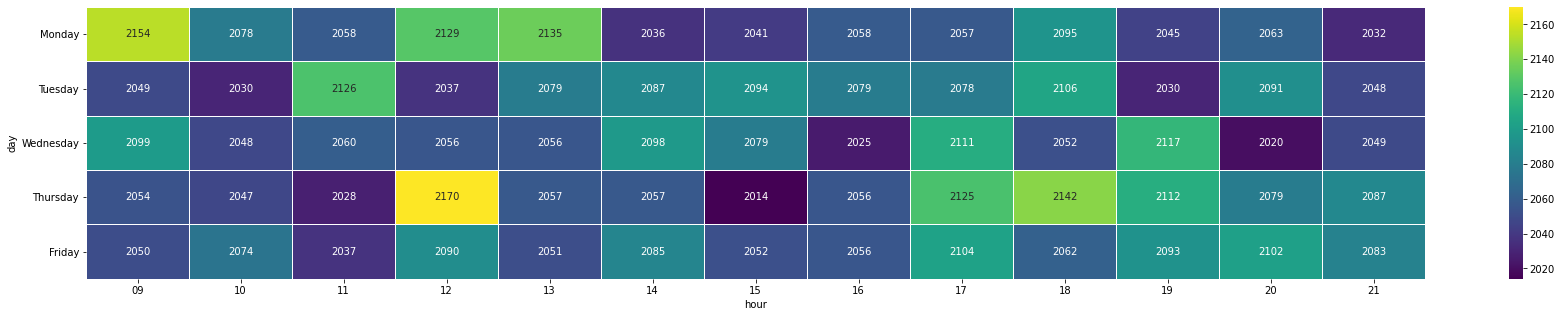

In [17]:
def heatmap(df, col, col_val):
    gb = df.groupby([col, 'day', 'hour'], as_index=False).agg({'device_ids': 'count'})
    pv = gb[gb[col] == col_val].pivot('day', 'hour', 'device_ids')
    _, ax = plot.subplots(figsize=(30, 5))
    sns.heatmap(pv, annot=True, fmt='.0f', cmap='viridis', linecolor='white', linewidths='0.5', ax=ax)

heatmap(dedupe, 'region', 'ON')

Apply visualization function through an interactive widget:

In [18]:
import ipywidgets as widgets

def heatmap_val(name):
    return heatmap(dedupe, 'name', name)

i = widgets.interact(heatmap_val, name=dedupe.name.unique().tolist())

interactive(children=(Dropdown(description='name', options=('Dominguez, Goodwin and Reese', 'Pham and Sons', '…

Or even a nested interactive widget of widgets:

In [19]:
def heatmap_col(col):

    def heatmap_val(val):
        return heatmap(dedupe, col, val)

    widgets.interact(heatmap_val, val=dedupe[col].unique().tolist())

i = widgets.interact(heatmap_col, col=['name', 'region'])

interactive(children=(Dropdown(description='col', options=('name', 'region'), value='name'), Output()), _dom_c…

Revise the visualization function to work with multiple dimensions in one pass:

In [20]:
def heatmap_2(df, region = None, name = None):
    cols = []
    conditions = []
    if region and region != 'ALL':
        cols.append('region')
        conditions.append(f'region == "{region}"')
    if name and name != 'ALL':
        cols.append('name')
        conditions.append(f'name == "{name}"')

    conditions = ' & '.join(conditions)
    if conditions:
        df = df.query(conditions)
    
    gb = df.groupby(['day', 'hour'], as_index=False).agg({'device_ids': 'count'})
    pv = gb.pivot('day', 'hour', 'device_ids')
    _, ax = plot.subplots(figsize=(30, 5))
    sns.heatmap(pv, annot=True, fmt='.0f', cmap='viridis', linecolor='white', linewidths='0.5', ax=ax)

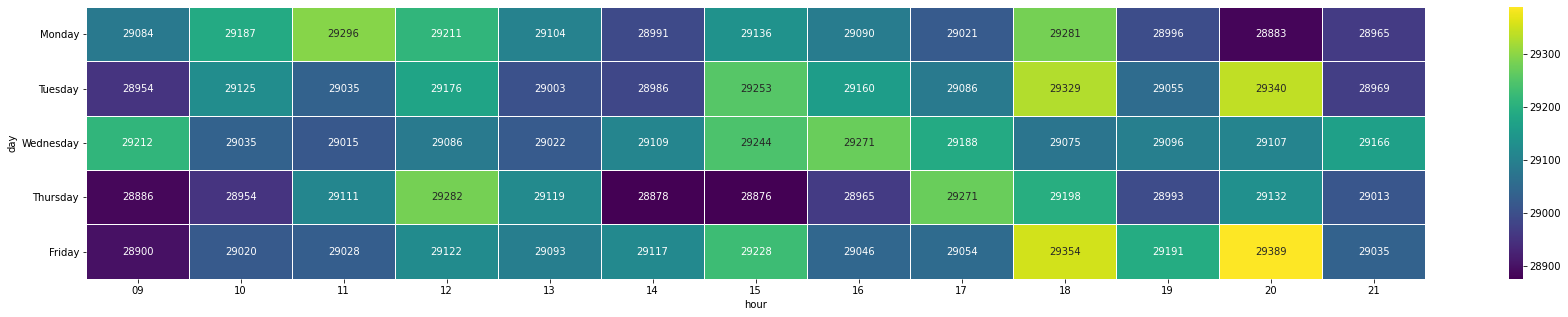

In [21]:
heatmap_2(dedupe, region='ALL', name='ALL')  # same as without region and name

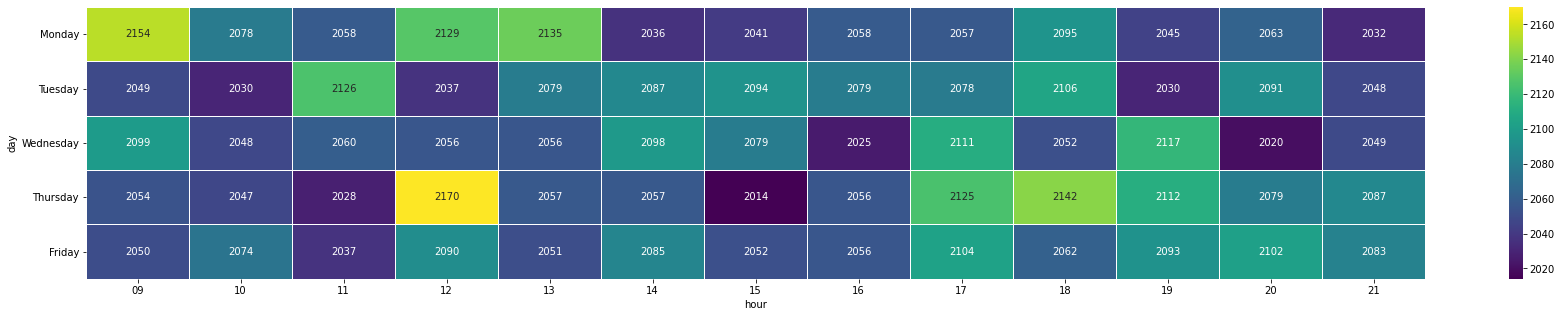

In [22]:
heatmap_2(dedupe, region='ON')

Stewart-Houston


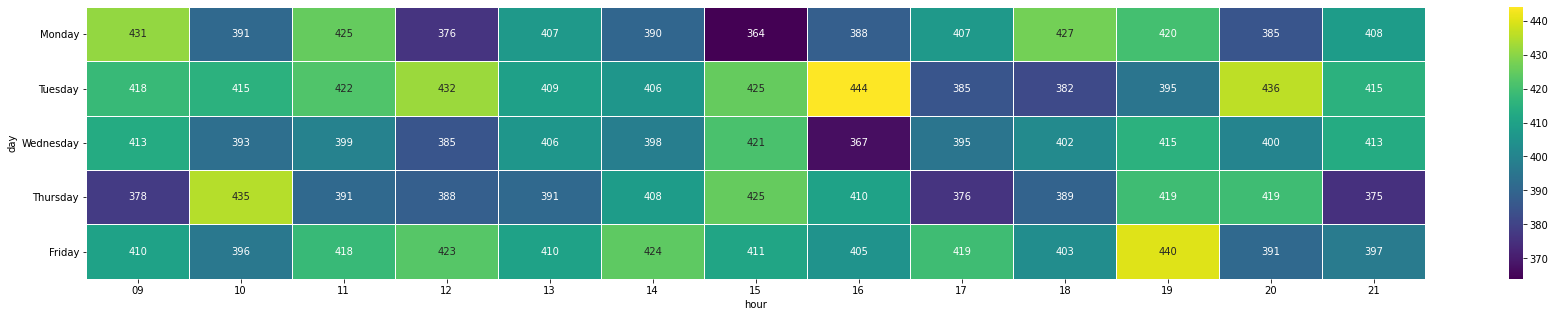

In [23]:
name = random.choice(dedupe.name.unique().tolist())
print(name)
heatmap_2(dedupe, name=name)

region: PE, name: Barr PLC


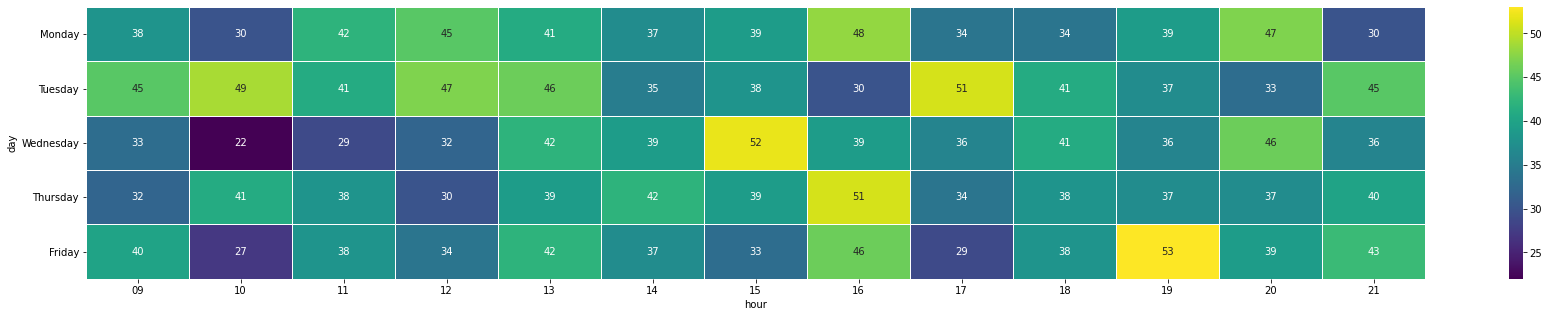

In [24]:
region = random.choice(dedupe.region.unique().tolist())
name = random.choice(dedupe.name.unique().tolist())
print(f'region: {region}, name: {name}')
heatmap_2(dedupe, region=region, name=name)

In [25]:
def heatmap_rn(region, name):
    return heatmap_2(dedupe, region, name)

i = widgets.interact(
    heatmap_rn,
    region=['ALL', *dedupe.region.unique().tolist()],
    name=['ALL', *dedupe.name.unique().tolist()],
)

interactive(children=(Dropdown(description='region', options=('ALL', 'NU', 'YT', 'AB', 'PE', 'NT', 'MB', 'QC',…

## Remarks

With a good understanding of the anticipated data schema, we can leverage generative techniques to:
* Unblock ourselves from idle-waiting for the actual data delivery
* Extend the volume and often statistical comprehensiveness of the data
* Revise data analysis processes to become more robust

## References

* Python built-in [random](https://docs.python.org/3/library/random.html) and [uuid](https://docs.python.org/3/library/uuid.html) modules
* [Faker](https://github.com/joke2k/faker) package
* [09 - Set operations](./09-set-operations.ipynb) and [10 - Bridging Web UI into Notebooks](10-bridging-web-ui-to-notebook.ipynb)